In [32]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
from astroquery.simbad import Simbad
from photutils import DAOStarFinder, CircularAperture, SkyCircularAperture, CircularAnnulus, aperture_photometry, Background2D, MedianBackground
from astropy.stats import sigma_clipped_stats
from astropy.table import Table, Column, hstack
import numpy
import os
import pylab
import glob
import seaborn as sns
from dateutil.parser import parse
from scipy.stats import sigmaclip
from astropy.stats import median_absolute_deviation, SigmaClip
import traceback

In [131]:
coef={
    "FLUX_R": 1.42e9*10**(-0.4*0.21),
    "FLUX_I": 1.00e9*10**(-0.4*0.45),
    "FLUX_u": 4.46e8*10**(-0.4*0.91),
    "FLUX_U": 4.46e8*10**(-0.4*0.79)
} ### MAYBE NEED TO HAVE AB CORRECTION

coef={
    "FLUX_R": 1.42e9,
    "FLUX_I": 1.00e9,
    "FLUX_u": 4.46e8,
    "FLUX_U": 4.46e8
}

In [132]:
def preprocess(path):
    # load fits file
    fh = fits.open(path)

    # reduce data
    header = fh[0].header
    data = fh[0].data[:header["MaxImgRows"], :header["MaxImgCols"]]
#    data = fh[0].data
    bias = numpy.outer(numpy.median(fh[0].data[:,header["MaxImgCols"]+10:],axis=1),numpy.ones(data.shape[1]))  # avoiding first 10 cols, row-by-row operation
    data = data - bias

    # sky subtraction
    sigma_clip = SigmaClip(sigma=3.)
    bkg_estimator = MedianBackground()

    # dividing the whole image by 4 in row
    for i in range(4):
        subsection = data[512*i:512*(i+1)]
        bkg = Background2D( subsection, (30, 30), filter_size=(3, 3),
                       sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
        data[512*i:512*(i+1)] = subsection - bkg.background
    
    new=fits.PrimaryHDU(data=data,header=header)
    new.writeto("{}".format("/".join([os.path.dirname(os.path.abspath(path)),"bg"+os.path.basename(path)])), overwrite=True)
    
    return data, header
    

In [133]:
def getrefcatalog( wcs ):
    # retrieve reference catalog
    c = SkyCoord(wcs.wcs.crval[0]*u.deg,wcs.wcs.crval[1]*u.deg)
    r = 15 * u.arcminute
    customSimbad = Simbad()
    customSimbad.add_votable_fields(
        "flux(U)",
        "flux_error(U)",
        "flux(R)",
        "flux_error(R)",
        "flux(I)",
        "flux_error(I)"
        )
    reference = customSimbad.query_region(c, radius=r)
    refcoord=SkyCoord(reference["RA"],reference["DEC"],unit=(u.hourangle, u.deg))
    return reference, refcoord

In [134]:
def getthroughput(path,wcs=None,plot=False):
    data, header=preprocess(path)

    if wcs is None:
        wcs = WCS(header)
    filterkey = "FLUX_{}".format(header["FILTER"][0].upper())
#    filterkey = "FLUX_{}".format(header["FILTER"][0])
    reference, refcoord = getrefcatalog(wcs)

    #    data = fh[0].data
    # detect objectcoef, need to optmize FWHM size
    mean, median, std = sigma_clipped_stats(data, sigma=3.0)  
    daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)  
    sources=daofind(data-median)
    # define positions where we measure
    positions = numpy.transpose([sources["xcentroid"], sources["ycentroid"]])
    aperture = CircularAperture(positions, r=5)
    annulus_aperture = CircularAnnulus(positions, r_in=8, r_out=10)
    # do photometry
    table = aperture_photometry(data,[aperture,annulus_aperture],wcs=wcs)
    table["flux"] = table["aperture_sum_0"]-table["aperture_sum_1"]*aperture.area/annulus_aperture.area    
#    idx, d2d, d3d = SkyCoord(wcs.all_pix2world((positions+xyoff),0),unit=("deg","deg")).match_to_catalog_sky(refcoord)    
    idx, d2d, d3d = aperture.to_sky(wcs).positions.match_to_catalog_sky(refcoord)
    table["d2d"] = d2d.to("arcsec")
    merged = hstack([Table(table), reference[idx]])[d2d<1*u.arcsec]

    obs = merged["flux"]*header["GAIN"]/header["EXPTIME"]
    expected =coef[filterkey]*10**(-0.4*merged[filterkey])
    x = obs/expected
    c, low, upp = sigmaclip(x[numpy.where((x>0)&(x<1))])
    med = numpy.median(c)
    err = median_absolute_deviation(c)

    if plot:
        ### PLOT IMAGE
        fig = pylab.figure(figsize=(5,5),dpi=200)
        pylab.subplot(projection=wcs)
        sky=numpy.median(data)
        std=median_absolute_deviation(data)
        aperture.plot(color='white', lw=0.1)
        annulus_aperture.plot(color='red', lw=0.1)

        pylab.imshow(data,origin="lower left",vmin=sky-3*std,vmax=sky+10*std,cmap="gray")

        refaperture = SkyCircularAperture(refcoord[(reference[filterkey]>0)&(reference[filterkey]<25)], r=2.*u.arcsec).to_pixel(wcs)
        refaperture.plot(color="green", lw=2, alpha=0.5)
        pylab.show()
        pylab.clf()

        ### CHECK PLOT
        sns.set(style="darkgrid")
        tips = sns.load_dataset("tips")

        #g = sns.JointGrid(x="total_bill", y="tip", data=tips)
        g = sns.JointGrid( merged[filterkey], obs/expected,ylim=(-0.05,1.05))
    #    g = sns.JointGrid( merged[filterkey], obs/expected )
    #    g.plot_joint(sns.kdeplot)
        g.plot_joint(sns.scatterplot)
        g.ax_marg_x.hist(
            merged[filterkey],
            bins=numpy.arange(11,20,0.5)
        )
        g.ax_marg_y.hist(
            obs/expected,
            orientation="horizontal",
            bins=numpy.arange(0,1,0.05)
        )
        g.set_axis_labels(xlabel="mag", ylabel="Throughput")

        pylab.axhline(med)    
        pylab.axhspan(med-err, med+err, alpha=0.5)
        pylab.suptitle(filterkey)

    return { "median": numpy.median(x), "std": median_absolute_deviation(x)}, header

In [135]:
result = {}
files = glob.glob("fwhm/HT*/HT*.new")
for i, afile in enumerate(files):
    print ("{}/{}".format(i,len(files)))
    try:
        print (afile)
        res, header = getthroughput(afile,plot=False)
        dt = parse("{}T{}".format(header["DATE-OBS"],header["UT"]))
        try:
            result[header["FILTER"]]["dt"].append( dt )
            result[header["FILTER"]]["median"].append( res["median"] )
            result[header["FILTER"]]["std"].append( res["std"] )
        except:
            result[header["FILTER"]] = {"dt": [ dt ], "median": [ res["median"] ], "std": [ res["std"] ] }
    except:
        traceback.print_exc()

0/187
fwhm/HT0000159-2/HT0000159-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


1/187
fwhm/HT0000166-1/HT0000166-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


2/187
fwhm/HT0000186-1/HT0000186-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


3/187
fwhm/HT0000187-1/HT0000187-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


4/187
fwhm/HT0000392-1/HT0000392-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


5/187
fwhm/HT0000130-1/HT0000130-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


6/187
fwhm/HT0000157-1/HT0000157-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


7/187
fwhm/HT0000165-2/HT0000165-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


8/187
fwhm/HT0000250-2/HT0000250-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


9/187
fwhm/HT0000290-2/HT0000290-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


10/187
fwhm/HT0000454-2/HT0000454-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


11/187
fwhm/HT0000189-1/HT0000189-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


12/187
fwhm/HT0000227-1/HT0000227-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


13/187
fwhm/HT0000331-2/HT0000331-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


14/187
fwhm/HT0000433-1/HT0000433-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


15/187
fwhm/HT0000453-1/HT0000453-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


16/187
fwhm/HT0000475-1/HT0000475-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


17/187
fwhm/HT0000125-1/HT0000125-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


18/187
fwhm/HT0000209-1/HT0000209-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


19/187
fwhm/HT0000290-1/HT0000290-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


20/187
fwhm/HT0000350-2/HT0000350-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


21/187
fwhm/HT0000126-2/HT0000126-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


22/187
fwhm/HT0000206-1/HT0000206-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


23/187
fwhm/HT0000229-1/HT0000229-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


24/187
fwhm/HT0000310-2/HT0000310-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


25/187
fwhm/HT0000142-2/HT0000142-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


26/187
fwhm/HT0000248-1/HT0000248-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


27/187
fwhm/HT0000248-2/HT0000248-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


28/187
fwhm/HT0000269-2/HT0000269-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


29/187
fwhm/HT0000473-2/HT0000473-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


30/187
fwhm/HT0000515-2/HT0000515-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


31/187
fwhm/HT0000125-2/HT0000125-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


32/187
fwhm/HT0000157-2/HT0000157-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


33/187
fwhm/HT0000206-2/HT0000206-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


34/187
fwhm/HT0000269-1/HT0000269-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


35/187
fwhm/HT0000332-1/HT0000332-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


36/187
fwhm/HT0000112-2/HT0000112-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


37/187
fwhm/HT0000127-1/HT0000127-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


38/187
fwhm/HT0000158-1/HT0000158-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


39/187
fwhm/HT0000188-1/HT0000188-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


40/187
fwhm/HT0000372-2/HT0000372-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


41/187
fwhm/HT0000132-2/HT0000132-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


42/187
fwhm/HT0000162-1/HT0000162-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


43/187
fwhm/HT0000333-2/HT0000333-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


44/187
fwhm/HT0000371-1/HT0000371-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


45/187
fwhm/HT0000310-1/HT0000310-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


46/187
fwhm/HT0000373-1/HT0000373-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


47/187
fwhm/HT0000164-2/HT0000164-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


48/187
fwhm/HT0000371-2/HT0000371-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


49/187
fwhm/HT0000555-2/HT0000555-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


50/187
fwhm/HT0000175-1/HT0000175-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


51/187
fwhm/HT0000186-2/HT0000186-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


52/187
fwhm/HT0000207-2/HT0000207-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


53/187
fwhm/HT0000227-2/HT0000227-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


54/187
fwhm/HT0000267-2/HT0000267-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


55/187
fwhm/HT0000415-2/HT0000415-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


56/187
fwhm/HT0000455-2/HT0000455-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


57/187
fwhm/HT0000126-1/HT0000126-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


58/187
fwhm/HT0000272-1/HT0000272-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


59/187
fwhm/HT0000311-2/HT0000311-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


60/187
fwhm/HT0000330-1/HT0000330-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


61/187
fwhm/HT0000535-1/HT0000535-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


62/187
fwhm/HT0000143-1/HT0000143-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


63/187
fwhm/HT0000160-1/HT0000160-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


64/187
fwhm/HT0000351-2/HT0000351-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


65/187
fwhm/HT0000374-2/HT0000374-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


66/187
fwhm/HT0000474-2/HT0000474-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


67/187
fwhm/HT0000535-2/HT0000535-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


68/187
fwhm/HT0000115-1/HT0000115-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


69/187
fwhm/HT0000167-2/HT0000167-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


70/187
fwhm/HT0000288-2/HT0000288-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


71/187
fwhm/HT0000352-2/HT0000352-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


72/187
fwhm/HT0000375-1/HT0000375-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


73/187
fwhm/HT0000434-2/HT0000434-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


74/187
fwhm/HT0000159-1/HT0000159-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


75/187
fwhm/HT0000228-1/HT0000228-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


76/187
fwhm/HT0000334-1/HT0000334-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


77/187
fwhm/HT0000374-1/HT0000374-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


78/187
fwhm/HT0000393-1/HT0000393-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


79/187
fwhm/HT0000495-1/HT0000495-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


80/187
fwhm/HT0000111-2/HT0000111-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


81/187
fwhm/HT0000144-1/HT0000144-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


82/187
fwhm/HT0000167-1/HT0000167-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


83/187
fwhm/HT0000268-1/HT0000268-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


84/187
fwhm/HT0000331-1/HT0000331-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


85/187
fwhm/HT0000113-1/HT0000113-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


86/187
fwhm/HT0000162-2/HT0000162-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


87/187
fwhm/HT0000247-2/HT0000247-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


88/187
fwhm/HT0000412-2/HT0000412-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


89/187
fwhm/HT0000415-1/HT0000415-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


90/187
fwhm/HT0000454-1/HT0000454-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


91/187
fwhm/HT0000474-1/HT0000474-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


92/187
fwhm/HT0000514-2/HT0000514-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


93/187
fwhm/HT0000127-2/HT0000127-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


94/187
fwhm/HT0000131-1/HT0000131-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


95/187
fwhm/HT0000184-2/HT0000184-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


96/187
fwhm/HT0000271-2/HT0000271-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


97/187
fwhm/HT0000312-1/HT0000312-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


98/187
fwhm/HT0000391-2/HT0000391-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


99/187
fwhm/HT0000435-2/HT0000435-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


100/187
fwhm/HT0000247-1/HT0000247-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


101/187
fwhm/HT0000309-2/HT0000309-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


102/187
fwhm/HT0000313-1/HT0000313-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


103/187
fwhm/HT0000353-2/HT0000353-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


104/187
fwhm/HT0000392-2/HT0000392-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


105/187
fwhm/HT0000433-2/HT0000433-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


106/187
fwhm/HT0000187-2/HT0000187-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


107/187
fwhm/HT0000289-2/HT0000289-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


108/187
fwhm/HT0000352-1/HT0000352-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


109/187
fwhm/HT0000413-2/HT0000413-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


110/187
fwhm/HT0000475-2/HT0000475-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


111/187
fwhm/HT0000113-2/HT0000113-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


112/187
fwhm/HT0000155-2/HT0000155-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


113/187
fwhm/HT0000161-2/HT0000161-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


114/187
fwhm/HT0000373-2/HT0000373-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


115/187
fwhm/HT0000395-1/HT0000395-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


116/187
fwhm/HT0000163-2/HT0000163-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


117/187
fwhm/HT0000170-2/HT0000170-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


118/187
fwhm/HT0000228-2/HT0000228-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


119/187
fwhm/HT0000251-1/HT0000251-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


120/187
fwhm/HT0000271-1/HT0000271-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


121/187
fwhm/HT0000289-1/HT0000289-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


122/187
fwhm/HT0000414-2/HT0000414-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


123/187
fwhm/HT0000453-2/HT0000453-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


124/187
fwhm/HT0000142-1/HT0000142-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


125/187
fwhm/HT0000144-2/HT0000144-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


126/187
fwhm/HT0000175-2/HT0000175-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


127/187
fwhm/HT0000188-2/HT0000188-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


128/187
fwhm/HT0000292-1/HT0000292-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


129/187
fwhm/HT0000353-1/HT0000353-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


130/187
fwhm/HT0000432-2/HT0000432-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


131/187
fwhm/HT0000494-1/HT0000494-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


132/187
fwhm/HT0000131-2/HT0000131-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


133/187
fwhm/HT0000412-1/HT0000412-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


134/187
fwhm/HT0000414-1/HT0000414-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


135/187
fwhm/HT0000208-2/HT0000208-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


136/187
fwhm/HT0000229-2/HT0000229-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


137/187
fwhm/HT0000330-2/HT0000330-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


138/187
fwhm/HT0000494-2/HT0000494-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


139/187
fwhm/HT0000143-2/HT0000143-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


140/187
fwhm/HT0000155-1/HT0000155-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


141/187
fwhm/HT0000291-2/HT0000291-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


142/187
fwhm/HT0000311-1/HT0000311-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


143/187
fwhm/HT0000394-2/HT0000394-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


144/187
fwhm/HT0000413-1/HT0000413-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


145/187
fwhm/HT0000112-1/HT0000112-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


146/187
fwhm/HT0000158-2/HT0000158-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


147/187
fwhm/HT0000207-1/HT0000207-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


148/187
fwhm/HT0000333-1/HT0000333-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


149/187
fwhm/HT0000354-1/HT0000354-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


150/187
fwhm/HT0000394-1/HT0000394-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


151/187
fwhm/HT0000435-1/HT0000435-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


152/187
fwhm/HT0000114-2/HT0000114-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


153/187
fwhm/HT0000141-1/HT0000141-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


154/187
fwhm/HT0000161-1/HT0000161-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


155/187
fwhm/HT0000164-1/HT0000164-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


156/187
fwhm/HT0000165-1/HT0000165-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


157/187
fwhm/HT0000166-2/HT0000166-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


158/187
fwhm/HT0000332-2/HT0000332-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


159/187
fwhm/HT0000351-1/HT0000351-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


160/187
fwhm/HT0000372-1/HT0000372-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


161/187
fwhm/HT0000130-2/HT0000130-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


162/187
fwhm/HT0000230-1/HT0000230-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


163/187
fwhm/HT0000268-2/HT0000268-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


164/187
fwhm/HT0000270-2/HT0000270-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


165/187
fwhm/HT0000312-2/HT0000312-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


166/187
fwhm/HT0000128-0/HT0000128-0.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/utsumi/anaconda3/

167/187
fwhm/HT0000249-1/HT0000249-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


168/187
fwhm/HT0000434-1/HT0000434-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


169/187
fwhm/HT0000495-2/HT0000495-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


170/187
fwhm/HT0000114-1/HT0000114-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


171/187
fwhm/HT0000226-2/HT0000226-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


172/187
fwhm/HT0000250-1/HT0000250-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


173/187
fwhm/HT0000132-1/HT0000132-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


174/187
fwhm/HT0000209-2/HT0000209-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


175/187
fwhm/HT0000205-2/HT0000205-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


176/187
fwhm/HT0000208-1/HT0000208-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


177/187
fwhm/HT0000185-2/HT0000185-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


178/187
fwhm/HT0000393-2/HT0000393-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


179/187
fwhm/HT0000455-1/HT0000455-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


180/187
fwhm/HT0000515-1/HT0000515-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


181/187
fwhm/HT0000249-2/HT0000249-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


182/187
fwhm/HT0000160-2/HT0000160-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


183/187
fwhm/HT0000145-2/HT0000145-2.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


184/187
fwhm/HT0000291-1/HT0000291-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


185/187
fwhm/HT0000170-1/HT0000170-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


186/187
fwhm/HT0000270-1/HT0000270-1.new


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)
/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)


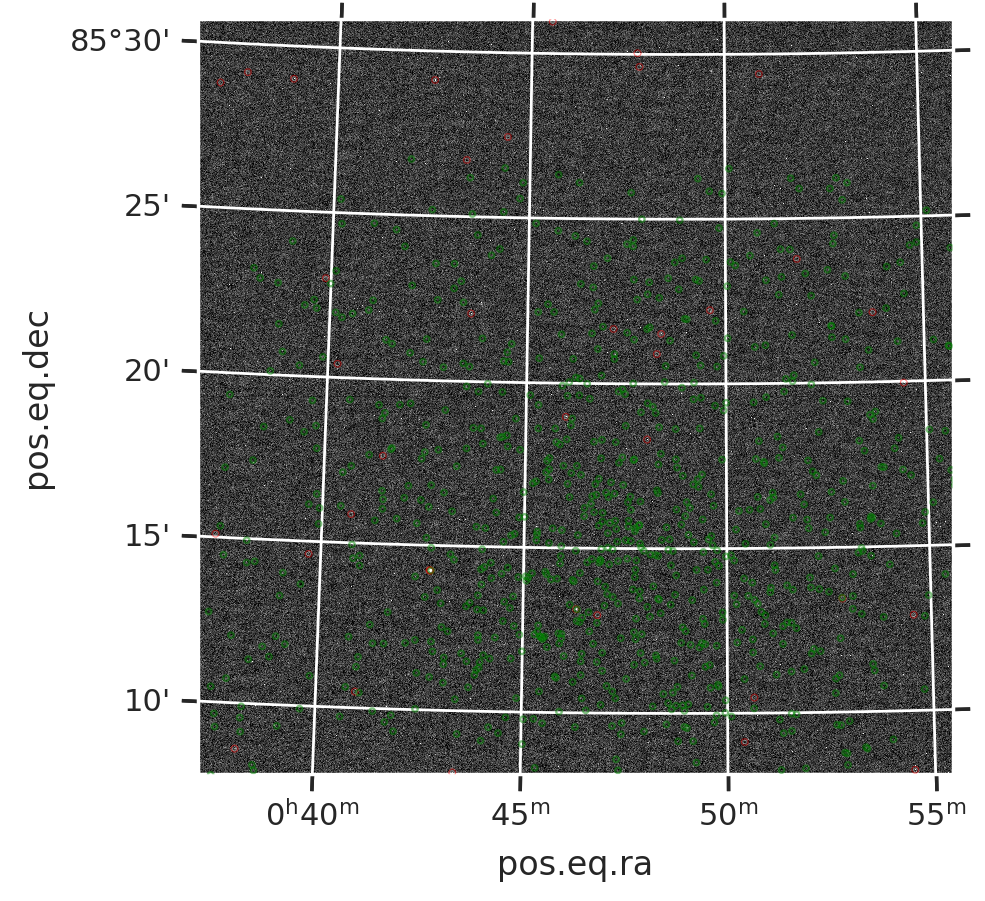

/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


<Figure size 432x288 with 0 Axes>

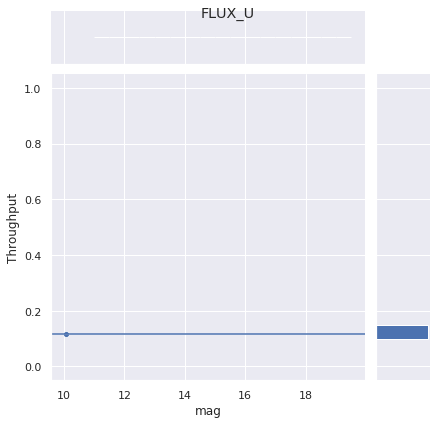

In [136]:
data, header = getthroughput("HT0000170-2/HT0000170-2.new",plot=False)
a=WCS(header).wcs
a.crpix = a.crpix-numpy.array([-5,14])
res, header = getthroughput("HT0000170-0.fits",WCS(a.to_header()),plot=True)

dt = parse("{}T{}".format(header["DATE-OBS"],header["UT"]))
result[header["FILTER"]]["dt"].append( dt )
result[header["FILTER"]]["median"].append( res["median"] )
result[header["FILTER"]]["std"].append( res["std"] )

In [137]:
glassbanketc = {
    "u": 0.616/0.946,   # take out a mirror because DM installed
    "Rc": 0.566/0.946,  # take out a mirror because DM installed
    "Ic": 0.601
}

def R(lam,t):
    alpha = numpy.exp(-2.3/100*t)
    theta = 0./180*numpy.pi
    sigma = 10+40*t
    return alpha*numpy.exp(-(4*numpy.pi*sigma*numpy.cos(theta)/lam)**2)

#lam = numpy.arange(3000,10000)
#for i in range(0,10):
#    pylab.plot(lam,R(lam,i))

lam = {
    "u": 3500.,
    "Rc": 6600.,
    "Ic": 8000.
}

/home/utsumi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Warning: converting a masked element to nan.
  after removing the cwd from sys.path.


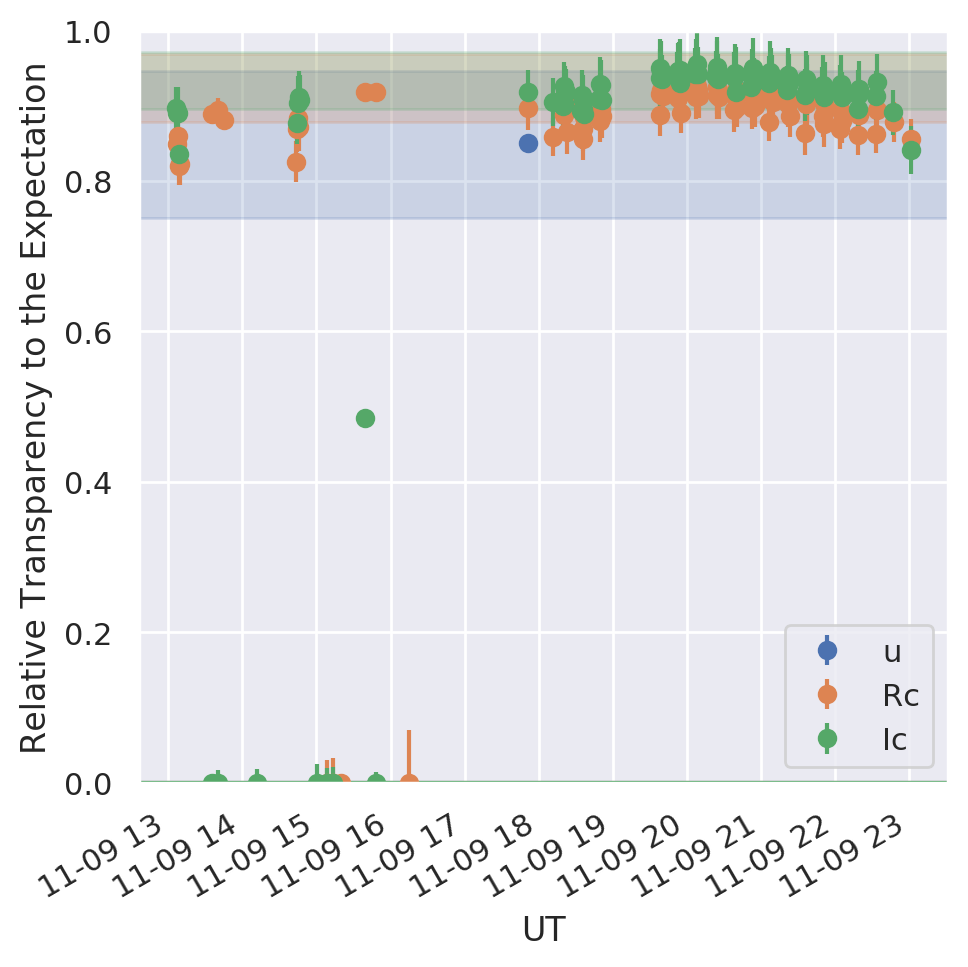

In [119]:
fig = pylab.figure(figsize=(5,5),dpi=200)
for key in ["u","Rc","Ic"]:
    x = result[key]["dt"]
    y = numpy.array(result[key]["median"])
    yerr = numpy.array(result[key]["std"])
    data = pylab.errorbar(x,y/glassbanketc[key],yerr=yerr/glassbanketc[key],fmt="o",label=key)
    pylab.axhline(color=data[0].get_color())
    pylab.axhspan(R(lam[key],1.),R(lam[key],3.),alpha=0.2,color=data[0].get_color())    

pylab.ylim(0,1)
pylab.legend()
pylab.ylabel("Relative Transparency to the Expectation")
pylab.xlabel("UT")
fig.autofmt_xdate()
pylab.tight_layout()

In [51]:
result["u"]

{'dt': [datetime.datetime(2019, 11, 9, 13, 51, 30)],
 'median': [nan],
 'std': [0.0]}

In [11]:
# arXiv:astro-ph/9907229
def acfregister(path,refpath):
    data, header=preprocess(path)
    refdata, refheader=preprocess(refpath)

    catalogs = []
    for img in [data, refdata]:
        mean, median, std = sigma_clipped_stats(img, sigma=3.0)  
        daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std, brightest=100)
        sources=daofind(img-median)
        # define positions where we measure
        positions = numpy.transpose([sources["xcentroid"], sources["ycentroid"]])
        catalogs.append(positions)
    return catalogs
    
catalogs = acfregister("HT0000405-0.fits","HT0000405-2/HT0000405-2.new")

In [12]:
catalogs[0].shape, catalogs[1].shape

((39, 2), (100, 2))

In [13]:
from scipy.signal import correlate2d
def getscalerot( catalogs, plot=False ):
    # determine scale and rotation
    if plot:
        fig = pylab.figure(figsize=(5,5),dpi=200)
    Harr = []
    for i in range(2):
        d = []
        phi = []
        # calculate d and phi for all possible pairs
        for a in catalogs[i]:
            for b in catalogs[i]:
                d.append( numpy.linalg.norm(a-b) )
                phi.append( numpy.arctan2(*(a-b)) )
        d = numpy.array(d)
        phi = numpy.array(phi)
        ld = numpy.log(d)
        X = numpy.arange(3,9,0.05)
        Y = numpy.arange(-numpy.pi,numpy.pi,0.05)
        # make a 2D histogram
        H, xedges, yedges = numpy.histogram2d(ld,phi,bins=[X,Y])
        Harr.append(H)
        if plot:
            pylab.subplot("13{}".format(i+1))
            pylab.imshow(H,origin="lower",extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]])
            pylab.ylabel(r"$\log(d)$")
            pylab.xlabel(r"$\phi$")
    # correlate them
    corr = correlate2d(Harr[0],Harr[1], boundary='symm', mode='same')
    y, x = numpy.unravel_index(numpy.argmax(corr), corr.shape)
    cy,cx = (numpy.array(2*yedges[-1],2*xedges[-1])/(numpy.array(corr.shape))*(numpy.array([y,x])+0.5)+numpy.array(-yedges[-1],-xedges[-1]))
    if plot:
        pylab.subplot(133)
        pylab.imshow(corr,origin="lower",extent=[-yedges[-1], yedges[-1], -xedges[-1], xedges[-1]])
#        pylab.scatter(cx,cy,marker="x",alpha=0.5)
        pylab.ylabel(r"$\log(d)$")
        pylab.xlabel(r"$\phi$")
    return cx,numpy.exp(cy)

/home/utsumi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


1.7407081139897027 1.1696755712494202


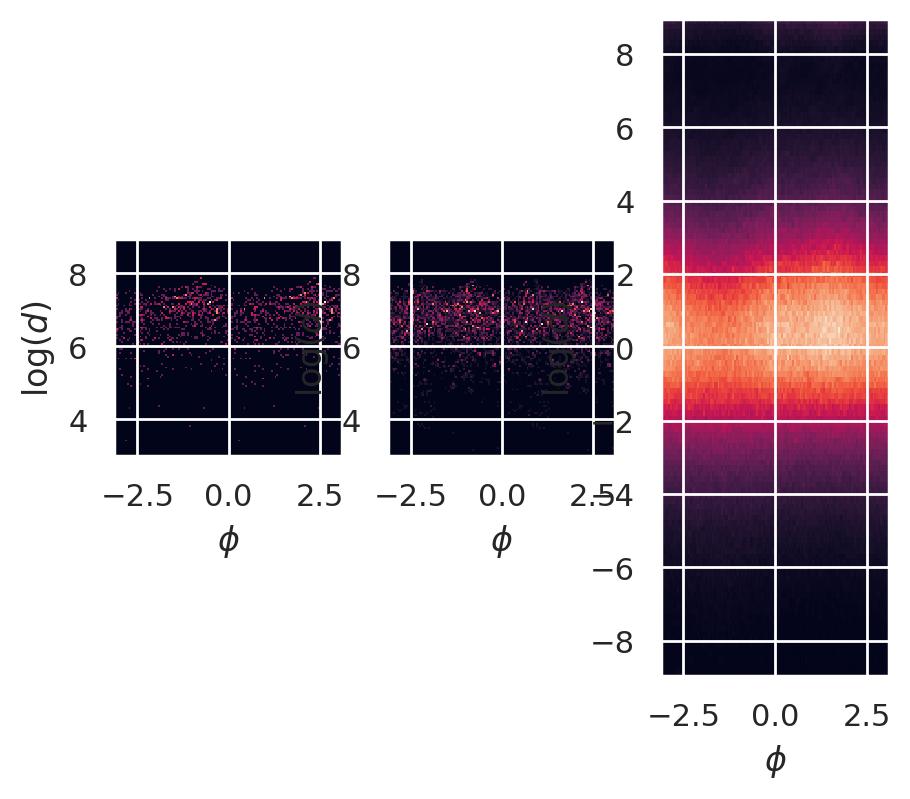

In [14]:
phi, scale = getscalerot([catalogs[0],catalogs[1]],plot=True)
print(phi,scale)

In [15]:
from scipy.ndimage.interpolation import rotate

c, s = numpy.cos(phi), numpy.sin(phi)
R = numpy.array([[c,-s],[s,c]])
newcatalog = []
for aobj in catalogs[0]:
    newcatalog.append(R@numpy.array(aobj))
#    print(rotate(aobj,angle=0/numpy.pi*180))
newcatalog = numpy.array(newcatalog)

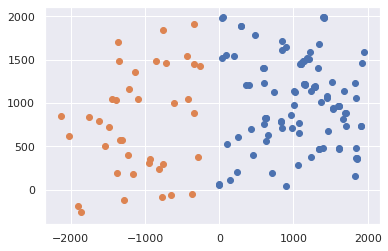

In [16]:
#pylab.scatter(*catalogs[0].T)

pylab.scatter(*catalogs[1].T)
pylab.scatter(*newcatalog.T)

/home/utsumi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


-1.6909735964471406 0.9490990239174838


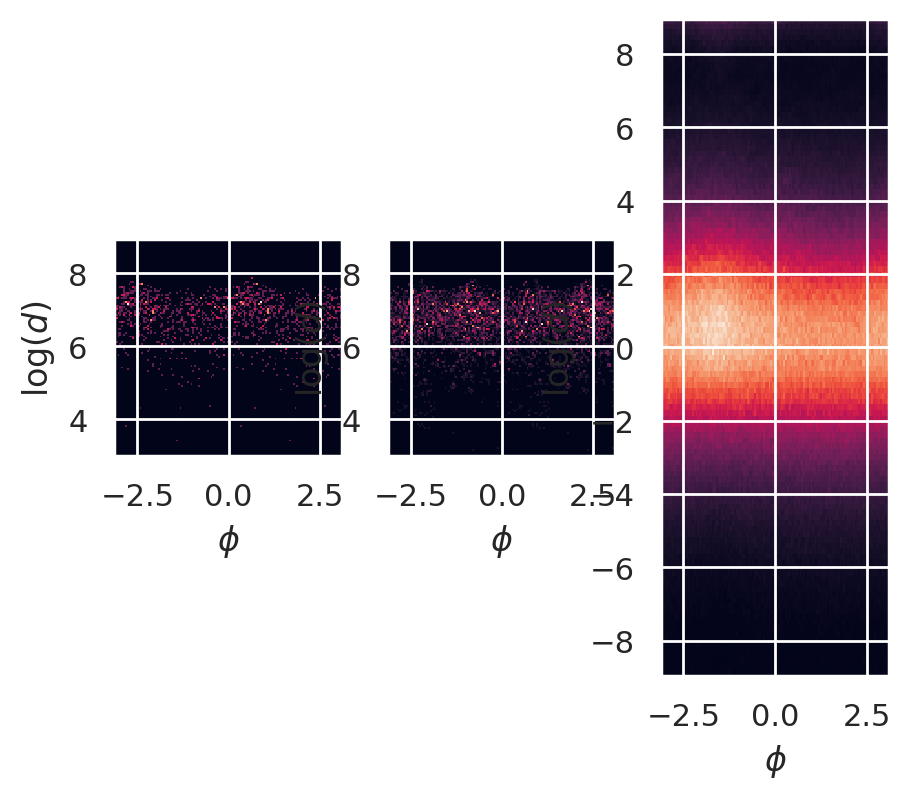

In [17]:
phi, scale = getscalerot([newcatalog,catalogs[1]],plot=True)
print(phi,scale)

In [18]:
WCS(header).wcs.crpix = WCS(header).wcs.crpix-numpy.array([-5,14])

In [19]:
a=WCS(header).wcs
a.crpix = a.crpix-numpy.array([-5,14])
WCS(a.to_header())

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 10.6152819891  85.2601190072  
CRPIX : 1418.19073486  738.24023438  
PC1_1 PC1_2  : -0.000188013034423  -5.00161217343e-06  
PC2_1 PC2_2  : -5.14476621415e-06  0.000186278511724  
CDELT : 1.0  1.0  
NAXIS : 0  0

In [20]:
print (a.crpix, a.crpix-numpy.array([-5,14]))


[1418.19073486  738.24023438] [1423.19073486  724.24023438]


In [21]:
print (a.crpix, a.crpix-numpy.array([-5,14]))
WCS(a.to_header())

[1418.19073486  738.24023438] [1423.19073486  724.24023438]


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 10.6152819891  85.2601190072  
CRPIX : 1418.19073486  738.24023438  
PC1_1 PC1_2  : -0.000188013034423  -5.00161217343e-06  
PC2_1 PC2_2  : -5.14476621415e-06  0.000186278511724  
CDELT : 1.0  1.0  
NAXIS : 0  0

0.5048523778637708
0.7596699032353843
0.7994651091311572


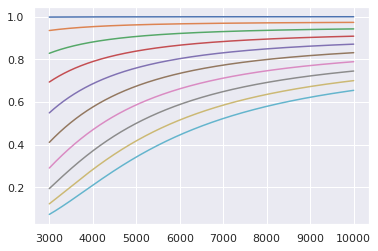

In [73]:
def R(lam,t):
    alpha = numpy.exp(-2.3/100*t)
    theta = 0./180*numpy.pi
    sigma = 10+40*t
    return alpha*numpy.exp(-(4*numpy.pi*sigma*numpy.cos(theta)/lam)**2)
lam = numpy.arange(3000,10000)
for i in range(0,10):
    pylab.plot(lam,R(lam,i))
for lam in [3500, 6600, 8000]:
    print(R(lam,5))

In [122]:
ret = getrefcatalog(WCS(header))

In [130]:
bib=ret[0].group_by("COO_BIBCODE")
bib.groups.keys

COO_BIBCODE
object
""
1998AJ....115.1693C
1998AJ....116.1789V
1998AJ....116.2644O
1999ApJ...520..548M
2002A&A...390..961A
2003AJ....126..276K
2003AJ....126.2922P
2003yCat.2246....0C
